# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching = False

In [4]:
example_dt = np.dtype([
    ('col', np.int64),
    ('idx', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 10, 21),
    (0, 1, 11, 22),
    (0, 2, 12, 23),
    (1, 0, 13, 24),
    (1, 1, 14, 25),
    (1, 2, 15, 26),
    (2, 0, 16, 27),
    (2, 1, 17, 28),
    (2, 2, 18, 29)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)
wrapper = vbt.tseries.common.TSArrayWrapper(index=['x', 'y', 'z'], columns=['a', 'b', 'c', 'd'], ndim=2, freq='1 days')
records = vbt.records.Records(records_arr, wrapper)

[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.random.uniform(size=1000000),
    np.random.uniform(size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)
big_wrapper = vbt.tseries.common.TSArrayWrapper(index=np.arange(1000), columns=np.arange(1000), ndim=2, freq='1 days')
big_records = vbt.records.Records(big_records_arr, big_wrapper)

(1000000,)


## MappedArray

In [7]:
mapped_array = records.map_field('some_field1')
big_mapped_array = big_records.map_field('some_field1')

In [8]:
print(mapped_array.mapped_arr)
print(mapped_array.col_arr)

[10. 11. 12. 13. 14. 15. 16. 17. 18.]
[0 0 0 1 1 1 2 2 2]


In [9]:
print(mapped_array.col_index)

%timeit big_mapped_array.col_index

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.18 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(mapped_array.to_matrix())
print(mapped_array.to_matrix(default_val=0.))

%timeit big_mapped_array.to_matrix()

      a     b     c   d
x  10.0  13.0  16.0 NaN
y  11.0  14.0  17.0 NaN
z  12.0  15.0  18.0 NaN
      a     b     c    d
x  10.0  13.0  16.0  0.0
y  11.0  14.0  17.0  0.0
z  12.0  15.0  18.0  0.0
960 ms ± 462 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
@njit
def mean_reduce_nb(col, a):
    return np.mean(a)

print(mapped_array.reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb, default_val=0.))
print(mapped_array.reduce(mean_reduce_nb, time_units=True))

%timeit big_mapped_array.reduce(mean_reduce_nb)

a    11.0
b    14.0
c    17.0
d     NaN
dtype: float64
a    11.0
b    14.0
c    17.0
d     0.0
dtype: float64
a   11 days
b   14 days
c   17 days
d       NaT
dtype: timedelta64[ns]
4.01 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
@njit
def min_max_reduce_nb(col, a):
    return np.array([np.min(a), np.max(a)])

print(mapped_array.reduce_to_array(min_max_reduce_nb))
print(mapped_array.reduce_to_array(min_max_reduce_nb, index=['min', 'max']))
print(mapped_array.reduce_to_array(min_max_reduce_nb, index=['min', 'max'], default_val=0.))
print(mapped_array.reduce_to_array(min_max_reduce_nb, time_units=True))

%timeit big_mapped_array.reduce_to_array(min_max_reduce_nb)

      a     b     c   d
0  10.0  13.0  16.0 NaN
1  12.0  15.0  18.0 NaN
        a     b     c   d
min  10.0  13.0  16.0 NaN
max  12.0  15.0  18.0 NaN
        a     b     c    d
min  10.0  13.0  16.0  0.0
max  12.0  15.0  18.0  0.0
        a       b       c   d
0 10 days 13 days 16 days NaT
1 12 days 15 days 18 days NaT
The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached.
48.4 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
print(mapped_array.nst(0))
print(mapped_array.nst(-1))

%timeit big_mapped_array.nst(0)

a    10.0
b    13.0
c    16.0
d     NaN
dtype: float64
a    12.0
b    15.0
c    18.0
d     NaN
dtype: float64
4.34 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(mapped_array.to_matrix().min())
print(mapped_array.min())

%timeit big_mapped_array.to_matrix().min()
%timeit big_mapped_array.min()

a    10.0
b    13.0
c    16.0
d     NaN
dtype: float64
a    10.0
b    13.0
c    16.0
d     NaN
dtype: float64
990 ms ± 362 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.39 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(mapped_array.to_matrix().max())
print(mapped_array.max())

%timeit big_mapped_array.to_matrix().max()
%timeit big_mapped_array.max()

a    12.0
b    15.0
c    18.0
d     NaN
dtype: float64
a    12.0
b    15.0
c    18.0
d     NaN
dtype: float64
685 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.71 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(mapped_array.to_matrix().mean())
print(mapped_array.mean())

%timeit big_mapped_array.to_matrix().mean()
%timeit big_mapped_array.mean()

a    11.0
b    14.0
c    17.0
d     NaN
dtype: float64
a    11.0
b    14.0
c    17.0
d     NaN
dtype: float64
1.06 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.59 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(mapped_array.to_matrix().median())
print(mapped_array.median())

%timeit big_mapped_array.to_matrix().median()
%timeit big_mapped_array.median()

a    11.0
b    14.0
c    17.0
d     NaN
dtype: float64
a    11.0
b    14.0
c    17.0
d     NaN
dtype: float64
675 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16.3 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(mapped_array.to_matrix().std())
print(mapped_array.std())

print(mapped_array.to_matrix().std(ddof=0.))
print(mapped_array.std(ddof=0.))

%timeit big_mapped_array.to_matrix().std()
%timeit big_mapped_array.std()

a    1.0
b    1.0
c    1.0
d    NaN
dtype: float64
a    1.0
b    1.0
c    1.0
d    NaN
dtype: float64
a    0.816497
b    0.816497
c    0.816497
d         NaN
dtype: float64
a    0.816497
b    0.816497
c    0.816497
d         NaN
dtype: float64
686 ms ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.76 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(mapped_array.to_matrix().sum())
print(mapped_array.sum())

%timeit big_mapped_array.to_matrix().sum()
%timeit big_mapped_array.sum()

a    33.0
b    42.0
c    51.0
d     0.0
dtype: float64
a    33.0
b    42.0
c    51.0
d     0.0
dtype: float64
742 ms ± 84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.82 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(mapped_array.to_matrix().count())
print(mapped_array.count())

%timeit big_mapped_array.to_matrix().count()
%timeit big_mapped_array.count()

a    3
b    3
c    3
d    0
dtype: int64
a    3
b    3
c    3
d    0
dtype: int64
883 ms ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.03 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(mapped_array.to_matrix().describe())
print(mapped_array.describe())

print(mapped_array.to_matrix().describe(percentiles=[0.3, 0.7]))
print(mapped_array.describe(percentiles=[0.3, 0.7]))

%timeit big_mapped_array.to_matrix().describe()
%timeit big_mapped_array.describe()

          a     b     c    d
count   3.0   3.0   3.0  0.0
mean   11.0  14.0  17.0  NaN
std     1.0   1.0   1.0  NaN
min    10.0  13.0  16.0  NaN
25%    10.5  13.5  16.5  NaN
50%    11.0  14.0  17.0  NaN
75%    11.5  14.5  17.5  NaN
max    12.0  15.0  18.0  NaN
          a     b     c    d
count   3.0   3.0   3.0  0.0
mean   11.0  14.0  17.0  NaN
std     1.0   1.0   1.0  NaN
min    10.0  13.0  16.0  NaN
25%    10.5  13.5  16.5  NaN
50%    11.0  14.0  17.0  NaN
75%    11.5  14.5  17.5  NaN
max    12.0  15.0  18.0  NaN
          a     b     c    d
count   3.0   3.0   3.0  0.0
mean   11.0  14.0  17.0  NaN
std     1.0   1.0   1.0  NaN
min    10.0  13.0  16.0  NaN
30%    10.6  13.6  16.6  NaN
50%    11.0  14.0  17.0  NaN
70%    11.4  14.4  17.4  NaN
max    12.0  15.0  18.0  NaN
          a     b     c    d
count   3.0   3.0   3.0  0.0
mean   11.0  14.0  17.0  NaN
std     1.0   1.0   1.0  NaN
min    10.0  13.0  16.0  NaN
30%    10.6  13.6  16.6  NaN
50%    11.0  14.0  17.0  NaN
70%    11.4  1

In [22]:
print(mapped_array.to_matrix().idxmin())
print(mapped_array.idxmin())

%timeit big_mapped_array.to_matrix().idxmin()
%timeit big_mapped_array.idxmin()

a      x
b      x
c      x
d    NaN
dtype: object
a      x
b      x
c      x
d    NaN
dtype: object
1.36 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.43 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(mapped_array.to_matrix().idxmax())
print(mapped_array.idxmax())

%timeit big_mapped_array.to_matrix().idxmax()
%timeit big_mapped_array.idxmax()

a      z
b      z
c      z
d    NaN
dtype: object
a      z
b      z
c      z
d    NaN
dtype: object
674 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.55 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
print(mapped_array['a'].mapped_arr)
print(mapped_array['a'].col_arr)
print(mapped_array['a'].wrapper.columns)
print(mapped_array[['a', 'b']].mapped_arr)
print(mapped_array[['a', 'b']].col_arr)
print(mapped_array[['a', 'b']].wrapper.columns)
print(mapped_array[['a', 'a']].mapped_arr)
print(mapped_array[['a', 'a']].col_arr)
print(mapped_array[['a', 'a']].wrapper.columns)

%timeit big_mapped_array.iloc[:, 0]
%timeit big_mapped_array.iloc[:, :]

[10. 11. 12.]
[0 0 0]
Index(['a'], dtype='object')
[10. 11. 12. 13. 14. 15.]
[0 0 0 1 1 1]
Index(['a', 'b'], dtype='object')
[10. 11. 12. 10. 11. 12.]
[0 0 0 1 1 1]
Index(['a', 'a'], dtype='object')
3.05 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.9 ms ± 6.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


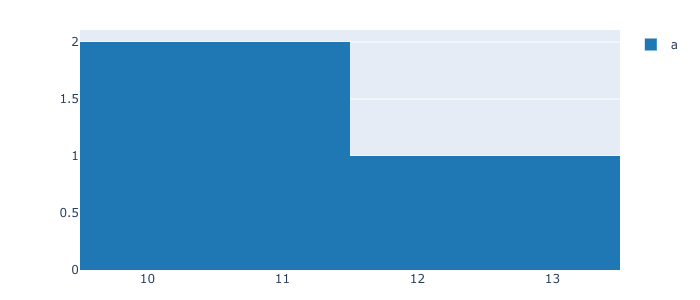

In [25]:
mapped_array['a'].hist().show_png()

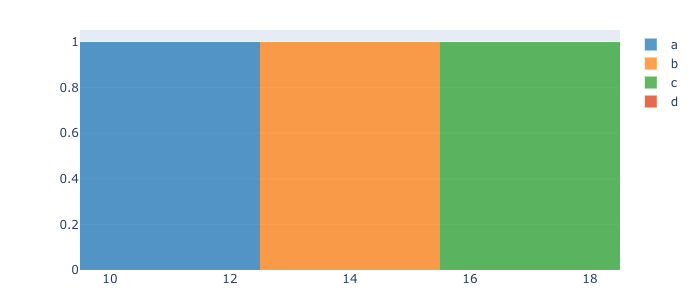

In [26]:
mapped_array.hist().show_png()

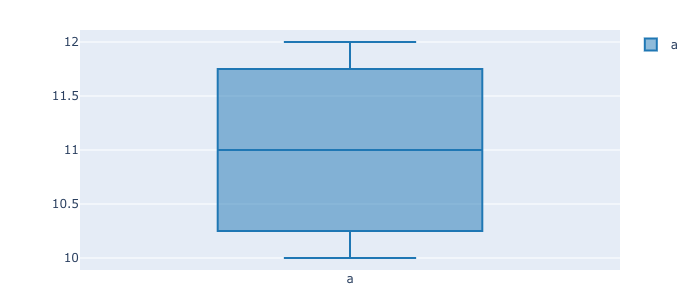

In [27]:
mapped_array['a'].box().show_png()

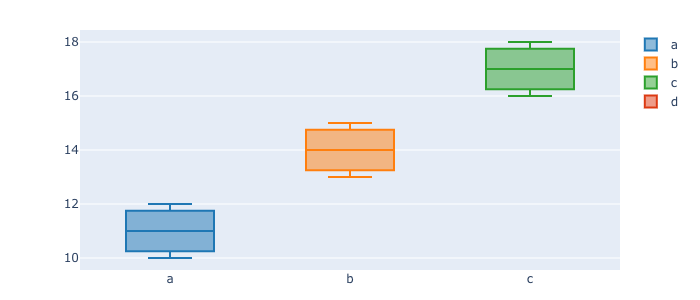

In [28]:
mapped_array.box().show_png()

## Records

In [29]:
print(records.records_arr)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
6.84 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [30]:
print(records.records)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
3    1    0         13.0         24.0
4    1    1         14.0         25.0
5    1    2         15.0         26.0
6    2    0         16.0         27.0
7    2    1         17.0         28.0
8    2    2         18.0         29.0


In [31]:
print(records.recarray)

%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
6.2 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
print(records.col_index)

%timeit big_records.col_index

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.37 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
@njit
def map_nb(record):
    return record.some_field1 + record.some_field2 * 2

print(records.map(map_nb))

%timeit big_records.map(map_nb)  # faster
%timeit vbt.records.MappedArray(\
    big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2,\
    big_records_arr['col'],\
    big_wrapper\
)

6.8 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.15 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
print(records.map_field('col').mapped_arr)
print(records.map_field('idx').mapped_arr)
print(records.map_field('some_field1').mapped_arr)
print(records.map_field('some_field2').mapped_arr)

%timeit big_records.map_field('some_field1')

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
[10. 11. 12. 13. 14. 15. 16. 17. 18.]
[21. 22. 23. 24. 25. 26. 27. 28. 29.]
14 µs ± 976 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
print(records.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).mapped_arr)

%timeit big_records.map_array(big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2)

[52. 55. 58. 61. 64. 67. 70. 73. 76.]
10.9 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
print(records.count)

%timeit big_records.count

a    3
b    3
c    3
d    0
dtype: int64
8.8 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(records['a'].records)
print(records['a'].wrapper.columns)
print(records[['a', 'b']].records)
print(records[['a', 'b']].wrapper.columns)
print(records[['a', 'a']].records)
print(records[['a', 'a']].wrapper.columns)

%timeit big_records.iloc[:, 0]
%timeit big_records.iloc[:, :]

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
Index(['a'], dtype='object')
   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
3    1    0         13.0         24.0
4    1    1         14.0         25.0
5    1    2         15.0         26.0
Index(['a', 'b'], dtype='object')
   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
3    1    0         10.0         21.0
4    1    1         11.0         22.0
5    1    2         12.0         23.0
Index(['a', 'a'], dtype='object')
4.99 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.6 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
filtered_records = vbt.records.Records(records_arr[[0, -1]], wrapper)
print(filtered_records.records)
print(filtered_records.col_index)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    2    2         18.0         29.0
[[ 0  1]
 [-1 -1]
 [ 1  2]
 [-1 -1]]


In [39]:
print(filtered_records['a'].records)
print(filtered_records['a'].col_index)
print(filtered_records['a'].map_field('some_field1').mapped_arr)
print(filtered_records['a'].map_field('some_field1').min())
print(filtered_records['a'].count)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
[[0 1]]
[10.]
10.0
1


In [40]:
print(filtered_records['b'].records)
print(filtered_records['b'].col_index)
print(filtered_records['b'].map_field('some_field1').mapped_arr)
print(filtered_records['b'].map_field('some_field1').min())
print(filtered_records['b'].count)

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
[]
nan
0


In [41]:
print(filtered_records['c'].records)
print(filtered_records['c'].col_index)
print(filtered_records['c'].map_field('some_field1').mapped_arr)
print(filtered_records['c'].map_field('some_field1').min())
print(filtered_records['c'].count)

   col  idx  some_field1  some_field2
0    0    2         18.0         29.0
[[0 1]]
[18.]
18.0
1


In [42]:
print(filtered_records['d'].records)
print(filtered_records['d'].col_index)
print(filtered_records['d'].map_field('some_field1').mapped_arr)
print(filtered_records['d'].map_field('some_field1').min())
print(filtered_records['d'].count)

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
[]
nan
0


## Drawdowns

In [43]:
from vectorbt.records import Drawdowns

In [44]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}).astype(np.float32)

print(ts)

     a    b    c    d
0  2.0  1.0  1.0  1.0
1  1.0  2.0  2.0  2.0
2  3.0  1.0  3.0  3.0
3  1.0  3.0  2.0  4.0
4  4.0  1.0  1.0  5.0
5  1.0  4.0  2.0  6.0


In [45]:
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))
big_ts.shape

(1000, 1000)

In [46]:
drawdowns = Drawdowns.from_ts(ts, freq='1 days')
big_drawdowns = Drawdowns.from_ts(big_ts, freq='1 days')

%timeit Drawdowns.from_ts(big_ts, freq='1 days')

7.93 ms ± 39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

print(drawdowns['b'].records)
print(drawdowns['b'].ts)

print(drawdowns['c'].records)
print(drawdowns['c'].ts)

print(drawdowns['d'].records)
print(drawdowns['d'].ts)

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
3    1          1           2        3       1
4    1          3           4        5       1
5    2          2           4        5       0
     a    b    c    d
0  2.0  1.0  1.0  1.0
1  1.0  2.0  2.0  2.0
2  3.0  1.0  3.0  3.0
3  1.0  3.0  2.0  4.0
4  4.0  1.0  1.0  5.0
5  1.0  4.0  2.0  6.0
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
0    2.0
1    1.0
2    3.0
3    1.0
4    4.0
5    1.0
Name: a, dtype: float32
   col  start_idx  valley_idx  end_idx  status
0    0          1           2        3       1
1    0          3           4        5       1
0    1.0
1    2.0
2    1.0
3    3.0
4    1.0
5    4.0
Name: b, dtype: float32
   col  start_idx  valley_idx  e

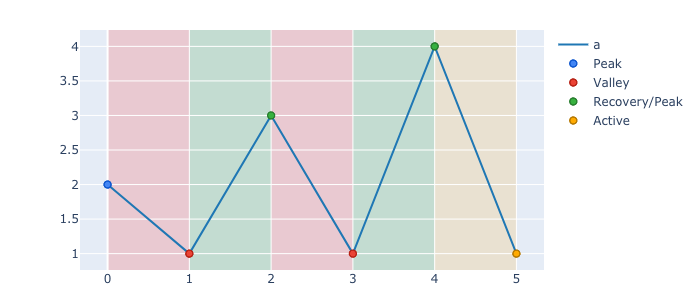

In [48]:
drawdowns['a'].plot().show_png()

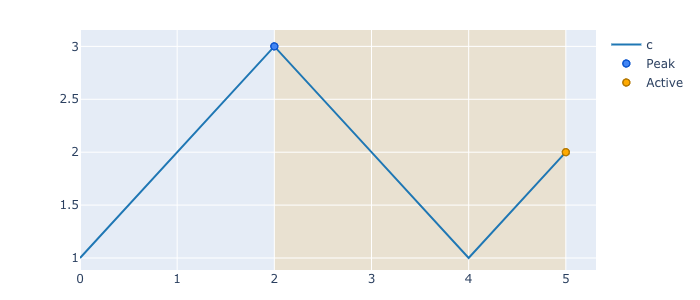

In [49]:
drawdowns['c'].plot().show_png()

In [50]:
print(drawdowns['a'].count)
print(drawdowns.count)

3
a    3
b    2
c    1
d    0
dtype: int64


In [51]:
print(drawdowns['a'].start_value.to_matrix())
print(drawdowns.start_value.to_matrix())

%timeit big_drawdowns.start_value

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    4.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  3.0  NaN  NaN NaN
5  4.0  3.0  3.0 NaN
2.88 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
print(drawdowns['a'].valley_value.to_matrix())
print(drawdowns.valley_value.to_matrix())

%timeit big_drawdowns.valley_value

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  1.0 NaN
1.99 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
print(drawdowns['a'].end_value.to_matrix())
print(drawdowns.end_value.to_matrix())

%timeit big_drawdowns.end_value

0    NaN
1    NaN
2    3.0
3    NaN
4    4.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  3.0  NaN  NaN NaN
3  NaN  3.0  NaN NaN
4  4.0  NaN  NaN NaN
5  1.0  4.0  2.0 NaN
2.37 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
print(drawdowns['a'].drawdown.to_matrix())
print(drawdowns.drawdown.to_matrix())

%timeit big_drawdowns.drawdown

0         NaN
1         NaN
2   -0.500000
3         NaN
4   -0.666667
5   -0.750000
Name: a, dtype: float64
          a         b         c   d
0       NaN       NaN       NaN NaN
1       NaN       NaN       NaN NaN
2 -0.500000       NaN       NaN NaN
3       NaN -0.500000       NaN NaN
4 -0.666667       NaN       NaN NaN
5 -0.750000 -0.666667 -0.666667 NaN
5.58 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
print(drawdowns['a'].avg_drawdown)
print(drawdowns.avg_drawdown)

%timeit big_drawdowns.avg_drawdown

-0.6388888955116272
a   -0.638889
b   -0.583333
c   -0.666667
d    0.000000
dtype: float64
4.76 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
print(drawdowns['a'].max_drawdown)
print(drawdowns.max_drawdown)

%timeit big_drawdowns.max_drawdown

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d    0.000000
dtype: float64
5.79 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
print(drawdowns['a'].duration.to_matrix())
print(drawdowns.duration.to_matrix())

%timeit big_drawdowns.duration

0    NaN
1    NaN
2    2.0
3    NaN
4    2.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  2.0  NaN  NaN NaN
5  1.0  2.0  3.0 NaN
760 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
print(drawdowns['a'].avg_duration)
print(drawdowns.avg_duration)

%timeit big_drawdowns.avg_duration

1 days 16:00:00
a   1 days 16:00:00
b   2 days 00:00:00
c   3 days 00:00:00
d               NaT
dtype: timedelta64[ns]
1.52 ms ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
print(drawdowns['a'].max_duration)
print(drawdowns.max_duration)

%timeit big_drawdowns.max_duration

2 days 00:00:00
a   2 days
b   2 days
c   3 days
d      NaT
dtype: timedelta64[ns]
1.56 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
print(drawdowns['a'].coverage)
print(drawdowns.coverage)

%timeit big_drawdowns.coverage

0.8333333333333334
a    0.833333
b    0.666667
c    0.500000
d    0.000000
dtype: float64
1.73 ms ± 85.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
print(drawdowns['a'].ptv_duration.to_matrix())
print(drawdowns.ptv_duration.to_matrix())

%timeit big_drawdowns.ptv_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  2.0 NaN
772 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
print(drawdowns['a'].status.to_matrix())
print(drawdowns.status.to_matrix())

%timeit big_drawdowns.status

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    0.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  0.0  1.0  0.0 NaN
9.17 µs ± 200 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [63]:
print(drawdowns['a'].recovered_rate)
print(drawdowns.recovered_rate)

%timeit big_drawdowns.recovered_rate

0.6666666666666666
a    0.666667
b    1.000000
c    0.000000
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/drawdowns.py:393: RuntimeWarning:

invalid value encountered in true_divide



5.39 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
1    2          2           4        5       0


In [65]:
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    1          1           2        3       1
3    1          3           4        5       1


In [66]:
%timeit big_drawdowns.active

367 µs ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
%timeit big_drawdowns.recovered

2.95 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
print(drawdowns['a'].active.current_drawdown)
print(drawdowns.active.current_drawdown)

%timeit big_drawdowns.active.current_drawdown

-0.75
a   -0.750000
b         NaN
c   -0.666667
d         NaN
dtype: float64
862 µs ± 39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [69]:
print(drawdowns['a'].active.current_duration)
print(drawdowns.active.current_duration)

%timeit big_drawdowns.active.current_duration

1 days 00:00:00
a   1 days
b      NaT
c   3 days
d      NaT
dtype: timedelta64[ns]
786 µs ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
print(drawdowns['a'].active.current_return)
print(drawdowns.active.current_return)

%timeit big_drawdowns.active.current_return

0.0
a    0.0
b    NaN
c    1.0
d    NaN
dtype: float64
861 µs ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
print(drawdowns['a'].recovered.recovery_return.to_matrix())
print(drawdowns.recovered.recovery_return.to_matrix())

%timeit big_drawdowns.recovered.recovery_return

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  2.0  NaN NaN NaN
3  NaN  2.0 NaN NaN
4  3.0  NaN NaN NaN
5  NaN  3.0 NaN NaN
8.75 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
print(drawdowns['a'].recovered.vtr_duration.to_matrix())
print(drawdowns.recovered.vtr_duration.to_matrix())

%timeit big_drawdowns.recovered.vtr_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  1.0  NaN NaN NaN
3  NaN  1.0 NaN NaN
4  1.0  NaN NaN NaN
5  NaN  1.0 NaN NaN
3.65 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
print(drawdowns['a'].recovered.vtr_duration_ratio.to_matrix())
print(drawdowns.recovered.vtr_duration_ratio.to_matrix())

%timeit big_drawdowns.recovered.vtr_duration_ratio

0    NaN
1    NaN
2    0.5
3    NaN
4    0.5
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  0.5  NaN NaN NaN
3  NaN  0.5 NaN NaN
4  0.5  NaN NaN NaN
5  NaN  0.5 NaN NaN
4.77 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Orders

In [74]:
from vectorbt.records import Orders, order_dt

In [75]:
from datetime import datetime
price = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}).astype(float)
print(price.shape)

big_price = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)).astype(float))
print(big_price.shape)

(7, 4)
(1000, 1000)


In [76]:
records_arr = np.asarray([
    (0, 2, 33.00330033, 3., 0.99009901, 0),
    (0, 3, 33.00330033, 4., 1.32013201, 1),
    (0, 4, 25.8798157, 5., 1.29399079, 0),
    (0, 6, 25.8798157, 7., 1.8115871, 1),
    (1, 2, 14.14427157, 7., 0.99009901, 0),
    (1, 3, 14.14427157, 6., 0.84865629, 1),
    (1, 4, 16.63702438, 5., 0.83185122, 0),
    (1, 5, 16.63702438, 4., 0.66548098, 1),
    (2, 0, 99.00990099, 1., 0.99009901, 0),
    (2, 1, 99.00990099, 2., 1.98019802, 1),
    (2, 6, 194.09861778, 1., 1.94098618, 0),
    (3, 2, 49.5049505, 2., 0.99009901, 0),
    (3, 4, 49.5049505, 2., 0.99009901, 1),
    (3, 6, 24.26232722, 4., 0.97049309, 0)
], dtype=order_dt)
print(records_arr.shape)
orders = Orders(records_arr, price, freq='1 days')

(14,)


In [77]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)
big_orders = vbt.records.Orders(big_records_arr, big_price, freq='1 days')

(1000000,)


In [78]:
print(orders.records)
print(orders['a'].records)
print(orders['b'].records)
print(orders['c'].records)
print(orders['d'].records)

    col  idx        size  price      fees  side
0     0    2   33.003300    3.0  0.990099     0
1     0    3   33.003300    4.0  1.320132     1
2     0    4   25.879816    5.0  1.293991     0
3     0    6   25.879816    7.0  1.811587     1
4     1    2   14.144272    7.0  0.990099     0
5     1    3   14.144272    6.0  0.848656     1
6     1    4   16.637024    5.0  0.831851     0
7     1    5   16.637024    4.0  0.665481     1
8     2    0   99.009901    1.0  0.990099     0
9     2    1   99.009901    2.0  1.980198     1
10    2    6  194.098618    1.0  1.940986     0
11    3    2   49.504950    2.0  0.990099     0
12    3    4   49.504950    2.0  0.990099     1
13    3    6   24.262327    4.0  0.970493     0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    3  33.003300    4.0  1.320132     1
2    0    4  25.879816    5.0  1.293991     0
3    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0   

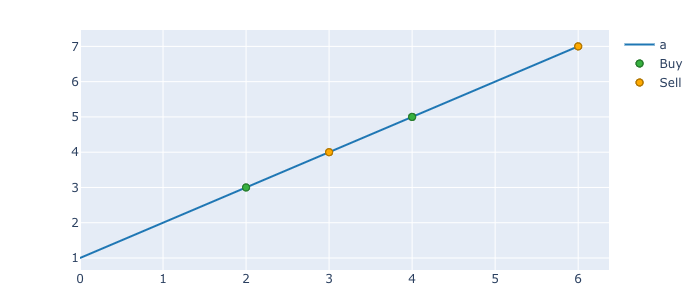

In [79]:
orders['a'].plot().show_png()

In [80]:
print(orders['a'].size.to_matrix())
print(orders.size.to_matrix())

%timeit big_orders.size

0          NaN
1          NaN
2    33.003300
3    33.003300
4    25.879816
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN   99.009901        NaN
2  33.003300  14.144272         NaN  49.504950
3  33.003300  14.144272         NaN        NaN
4  25.879816  16.637024         NaN  49.504950
5        NaN  16.637024         NaN        NaN
6  25.879816        NaN  194.098618  24.262327
15.7 µs ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [81]:
print(orders['a'].price.to_matrix())
print(orders.price.to_matrix())

%timeit big_orders.price

0    NaN
1    NaN
2    3.0
3    4.0
4    5.0
5    NaN
6    7.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  1.0  NaN
1  NaN  NaN  2.0  NaN
2  3.0  7.0  NaN  2.0
3  4.0  6.0  NaN  NaN
4  5.0  5.0  NaN  2.0
5  NaN  4.0  NaN  NaN
6  7.0  NaN  1.0  4.0
10.2 µs ± 742 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [82]:
print(orders['a'].fees.to_matrix())
print(orders.fees.to_matrix())

%timeit big_orders.fees

0         NaN
1         NaN
2    0.990099
3    1.320132
4    1.293991
5         NaN
6    1.811587
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN  0.990099       NaN
1       NaN       NaN  1.980198       NaN
2  0.990099  0.990099       NaN  0.990099
3  1.320132  0.848656       NaN       NaN
4  1.293991  0.831851       NaN  0.990099
5       NaN  0.665481       NaN       NaN
6  1.811587       NaN  1.940986  0.970493
13.9 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [83]:
print(orders['a'].side.to_matrix())
print(orders.side.to_matrix())

%timeit big_orders.side

0    NaN
1    NaN
2    0.0
3    1.0
4    0.0
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  0.0  NaN
1  NaN  NaN  1.0  NaN
2  0.0  0.0  NaN  0.0
3  1.0  1.0  NaN  NaN
4  0.0  0.0  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
14.5 µs ± 7.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [84]:
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx        size  price      fees  side
0    0    2   33.003300    3.0  0.990099     0
1    0    4   25.879816    5.0  1.293991     0
2    1    2   14.144272    7.0  0.990099     0
3    1    4   16.637024    5.0  0.831851     0
4    2    0   99.009901    1.0  0.990099     0
5    2    6  194.098618    1.0  1.940986     0
6    3    2   49.504950    2.0  0.990099     0
7    3    6   24.262327    4.0  0.970493     0


In [85]:
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
2    1    3  14.144272    6.0  0.848656     1
3    1    5  16.637024    4.0  0.665481     1
4    2    1  99.009901    2.0  1.980198     1
5    3    4  49.504950    2.0  0.990099     1


In [86]:
%timeit big_orders.buy

20.4 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [87]:
%timeit big_orders.sell

29.6 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
print(orders['a'].buy.size.to_matrix())
print(orders.buy.size.to_matrix())

%timeit big_orders.buy.size

0          NaN
1          NaN
2    33.003300
3          NaN
4    25.879816
5          NaN
6          NaN
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN         NaN        NaN
2  33.003300  14.144272         NaN  49.504950
3        NaN        NaN         NaN        NaN
4  25.879816  16.637024         NaN        NaN
5        NaN        NaN         NaN        NaN
6        NaN        NaN  194.098618  24.262327
18.9 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
print(orders['a'].sell.size.to_matrix())
print(orders.sell.size.to_matrix())

%timeit big_orders.sell.size

0          NaN
1          NaN
2          NaN
3    33.003300
4          NaN
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  99.009901       NaN
2        NaN        NaN        NaN       NaN
3  33.003300  14.144272        NaN       NaN
4        NaN        NaN        NaN  49.50495
5        NaN  16.637024        NaN       NaN
6  25.879816        NaN        NaN       NaN
23.6 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Trades

In [90]:
from vectorbt.records import Trades

In [91]:
trades = Trades.from_orders(orders)
print(trades.records_arr.shape)

(8,)


In [92]:
big_trades = Trades.from_orders(big_orders)
print(big_trades.records_arr.shape)

(500000,)


In [93]:
%timeit Trades.from_orders(big_orders)

34.2 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
print(trades.records)
print(trades['a'].records)
print(trades['b'].records)
print(trades['c'].records)
print(trades['d'].records)

   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   33.003300          2          3.0    0.990099         3         4.0   
1    0   25.879816          4          5.0    1.293991         6         7.0   
2    1   14.144272          2          7.0    0.990099         3         6.0   
3    1   16.637024          4          5.0    0.831851         5         4.0   
4    2   99.009901          0          1.0    0.990099         1         2.0   
5    2  194.098618          6          1.0    1.940986         6         1.0   
6    3   49.504950          2          2.0    0.990099         4         2.0   
7    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
2   0.848656 -15.983027 -0.159830       1             2  
3   0.665481 -18.134357 -0.215842       1      

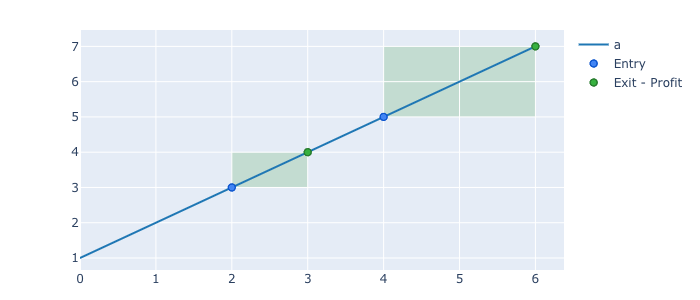

In [95]:
trades['a'].plot().show_png()

In [96]:
print(trades['a'].count)
print(trades.count)

%timeit big_trades.count

2
a    2
b    2
c    2
d    2
dtype: int64
6.68 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
print(trades['a'].duration.to_matrix())
print(trades.duration.to_matrix())

%timeit big_trades.duration

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    2.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  2.0
5  NaN  1.0  NaN  NaN
6  2.0  NaN  0.0  0.0
7.88 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
print(trades['a'].coverage)
print(trades.coverage)

%timeit big_trades.coverage

0.42857142857142855
a    0.428571
b    0.285714
c    0.142857
d    0.285714
dtype: float64
13.1 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
print(trades['a'].pnl.to_matrix())
print(trades.pnl.to_matrix())

%timeit big_trades.pnl

0          NaN
1          NaN
2          NaN
3    30.693069
4          NaN
5          NaN
6    48.654054
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  96.039604       NaN
2        NaN        NaN        NaN       NaN
3  30.693069 -15.983027        NaN       NaN
4        NaN        NaN        NaN -1.980198
5        NaN -18.134357        NaN       NaN
6  48.654054        NaN  -1.940986 -0.970493
10.4 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [100]:
print(trades['a'].returns.to_matrix())
print(trades.returns.to_matrix())

%timeit big_trades.returns

0         NaN
1         NaN
2         NaN
3    0.306931
4         NaN
5         NaN
6    0.372277
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN       NaN       NaN
1       NaN       NaN  0.960396       NaN
2       NaN       NaN       NaN       NaN
3  0.306931 -0.159830       NaN       NaN
4       NaN       NaN       NaN -0.019802
5       NaN -0.215842       NaN       NaN
6  0.372277       NaN -0.009901 -0.009901
15 µs ± 3.92 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [101]:
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816 

In [102]:
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    1   14.144272          2          7.0    0.990099         3         6.0   
1    1   16.637024          4          5.0    0.831851         5         4.0   
2    2  194.098618          6          1.0    1.940986         6         1.0   
3    3   49.504950          2          2.0    0.990099         4         2.0   
4    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees        pnl    return  status  position_idx  
0   0.848656 -15.983027 -0.159830       1             2  
1   0.665481 -18.134357 -0.215842       1             3  
2   0.000000  -1.940986 -0.009901       0  

In [103]:
%timeit big_trades.winning

21.1 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
%timeit big_trades.losing

The slowest run took 9.40 times longer than the fastest. This could mean that an intermediate result is being cached.
48.4 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
print(trades['a'].win_rate)
print(trades.win_rate)

%timeit big_trades.win_rate

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
39.9 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
print(trades['a'].profit_factor)
print(trades.profit_factor)

%timeit big_trades.profit_factor

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/events.py:309: RuntimeWarning:

divide by zero encountered in true_divide



inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64
55.7 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
print(trades['a'].expectancy)
print(trades.expectancy)

%timeit big_trades.expectancy

39.673561410000005
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
77.3 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [108]:
print(trades['a'].sqn)
print(trades.sqn)

%timeit big_trades.sqn

4.417749157643597
a     4.417749
b   -15.858742
c     0.960380
d    -2.922330
dtype: float64
18.6 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
print(trades['a'].status.to_matrix())
print(trades.status.to_matrix())

%timeit big_trades.status

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
11.5 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [110]:
print(trades['a'].closed_rate)
print(trades.closed_rate)

%timeit big_trades.closed_rate

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
56.5 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    2  194.098618          6          1.0    1.940986         6         1.0   
1    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees       pnl    return  status  position_idx  
0        0.0 -1.940986 -0.009901       0             5  
1        0.0 -0.970493 -0.009901       0             7  


In [112]:
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816 

In [113]:
%timeit big_trades.open # less records

4.91 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [114]:
%timeit big_trades.closed # almost all

The slowest run took 5.61 times longer than the fastest. This could mean that an intermediate result is being cached.
85.5 ms ± 53.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [115]:
print(trades['a'].position_idx.to_matrix())
print(trades.position_idx.to_matrix())

%timeit big_trades.position_idx

0    NaN
1    NaN
2    NaN
3    0.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  4.0  NaN
2  NaN  NaN  NaN  NaN
3  0.0  2.0  NaN  NaN
4  NaN  NaN  NaN  6.0
5  NaN  3.0  NaN  NaN
6  1.0  NaN  5.0  7.0
10.8 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Positions

In [116]:
from vectorbt.records import Positions

In [117]:
positions = Positions.from_orders(orders)
print(positions.records_arr.shape)

(8,)


In [118]:
big_positions = Positions.from_orders(big_orders)
print(big_positions.records_arr.shape)

(500000,)


In [119]:
%timeit Positions.from_orders(big_orders)

22.5 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
print(positions.records)
print(positions['a'].records)
print(positions['b'].records)
print(positions['c'].records)
print(positions['d'].records)

   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   33.003300          2          3.0    0.990099         3         4.0   
1    0   25.879816          4          5.0    1.293991         6         7.0   
2    1   14.144272          2          7.0    0.990099         3         6.0   
3    1   16.637024          4          5.0    0.831851         5         4.0   
4    2   99.009901          0          1.0    0.990099         1         2.0   
5    2  194.098618          6          1.0    1.940986         6         4.0   
6    3   49.504950          2          2.0    0.990099         4         2.0   
7    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees         pnl    return  status  
0   1.320132   30.693069  0.306931       1  
1   1.811587   48.654054  0.372277       1  
2   0.848656  -15.983027 -0.159830       1  
3   0.665481  -18.134357 -0.215842       1  
4   1.980198   96.039604  0.960396       1  
5   0.000

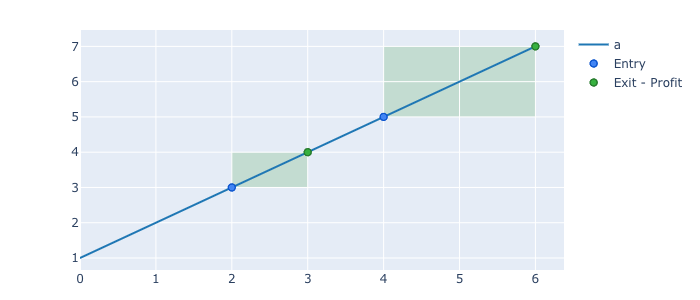

In [121]:
positions['a'].plot().show_png()